In [1]:
import os
import rioxarray as rxr
import xarray as xr
from dataclasses import asdict
from dscreator.cfarray.attributes import DatasetAttrsGrid, VariableAttrs
from datetime import datetime
from dscreator import utils
from dscreator.storage import get_storage_handler

The rapport can be found [here](https://niva365.sharepoint.com/sites/projects/3383/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=A7HwOO&CT=1678890409578&OR=OWA%2DNT&CID=4ae0ac88%2Ddc20%2D15e6%2D4318%2D5052c4a4fa9e&FolderCTID=0x01200023B9EEB8E9C0094580920107C7844708&id=%2Fsites%2Fprojects%2F3383%2FShared%20Documents%2FProjects%2F2017%20T%C3%A5legrenseprosjekt%2FRapport&viewid=aa29078f%2D5cb7%2D41dd%2Da376%2D38bbe9dc6fa4)
Notes:

* The Steady-State Water Chemistry (SSWC), som beregner tålegrenser for sterk syre og overskridelse med utgangspunkt i at utlekkingen av nitrogen forblir konstant på dagens nivå.  
* The First-order Acidity Balance (FAB), calculates limits for sulphur og nitrogen

In [2]:
da_fab_tif = rxr.open_rasterio(os.path.join("data", "fab_exceed_ns_12_16_meq1.tif"))
da_fab_tif.name = "fab"
da_fab_tif.attrs.update(asdict(
    VariableAttrs(long_name="First-order Acidity Balance", units="mEkv/m^2/year", short_name="FAB")
))
da_fab_tif = da_fab_tif.rio.reproject("EPSG:4326")
da_sswc_tif = rxr.open_rasterio(os.path.join("data", "sswc_exceed_12_16_meq1.tif"))
da_sswc_tif.name = "sswc"
da_sswc_tif.attrs.update(asdict(
    VariableAttrs(long_name="Steady-State Water Chemistry ", units="mEkv/m^2/year", short_name="sswc")
))
da_sswc_tif = da_sswc_tif.rio.reproject("EPSG:4326")

In [3]:
ds = xr.merge([da_fab_tif, da_sswc_tif])

In [6]:
ds.attrs = asdict(DatasetAttrsGrid(
            title="Test limits",
            title_no="Test grenser",
            summary="Test limits summary",
            summary_no="Test grenser oppsummering",
            #https://gcmd.earthdata.nasa.gov/KeywordViewer
            keywords=",".join(
                [
                    "GCMDSK:EARTH SCIENCE > LAND SURFACE > SOILS > NITROGEN",
                    "GCMDSK:EARTH SCIENCE > LAND SURFACE > SOILS > SULFUR",
                    "GCMDLOC:CONTINENT > EUROPE > NORTHERN EUROPE > SCANDINAVIA > NORWAY",
                ]
            ),
            keywords_vocabulary=",".join(
                [
                    "GCMDSK:GCMD Science Keywords:https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                    "GCMDLOC:GCMD Locations:https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/locations",
                ]
            ),
            iso_topic_category="environment",
            spatial_representation="grid",
            date_created=str(datetime.now()),
            project="Test Limits",
            time_coverage_start=utils.to_isoformat(datetime(2012, 1, 1)),
            time_coverage_end=utils.to_isoformat(datetime(2012, 1, 1)),
            geospatial_lon_min=float(ds.x.min()),
            geospatial_lon_max=float(ds.x.max()),
            geospatial_lat_min=float(ds.y.min()),
            geospatial_lat_max=float(ds.y.max()),
            history=f"dscreator({str(datetime.now())}) reprojected to EPSG:4326 and populated metadata"
        ))

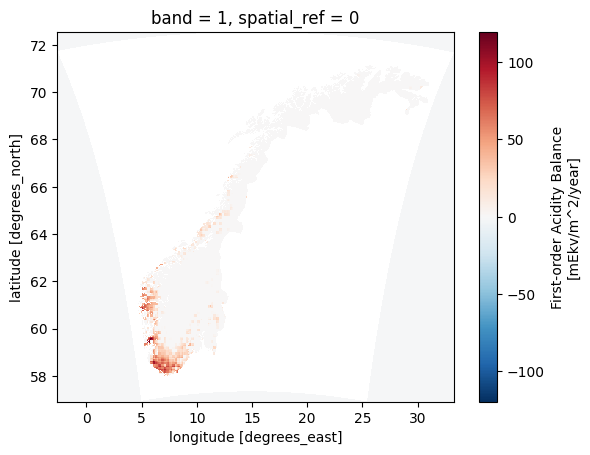

In [5]:
ds.fab.plot()

In [7]:
storage = get_storage_handler("limits", "acid-nitrogen")
storage.save_dataset(ds)